In [1]:
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim as optim
from jaxtyping import Float, Int
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import transformers

c:\Users\Colton\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# "CUDA" means a GPU device -- it makes the training much faster!
DEVICE: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{DEVICE = }")

DEVICE = device(type='cpu')


# Attention Head in math

$$
	A(X) = \sigma\bigg(X W_Q W_K^T X^T + M\bigg) X W_V W_O^T
$$

- $W_Q, W_K, W_V, W_O$ can be made with `nn.Linear` and will all have dimension `d_model` $\times$ `d_head`
- $M$ is a lower triangular mask matrix, look up how to do this

In [3]:
def create_mask(n_context: int) -> Float[torch.Tensor, "n_context n_context"]:
	# this should return a `n_context, n_context` matrix,
	# with zeros below and on the diag, and `-float("inf")` below
	# output = ...
	mask = np.full((n_context, n_context), -np.inf, dtype=np.float64)
	mask[np.tril_indices_from(mask)] = 0
	return torch.Tensor(mask)

In [4]:
# NOTE: it's intentional that `n_context` is not in the `GPTConfig`
@dataclass
class GPTConfig:
	# default test values -- too small for a real language model, but big enough for testing
	d_vocab: int = 40_000
	d_model: int = 128
	d_mlp: int = 512
	n_heads: int = 4
	d_head: int = 32
	n_layers: int = 6
	act_fn: type[nn.Module] = nn.ReLU

	@property
	def n_params(self) -> int:
		"an estimate of the number of parameters"
		return (
			self.d_vocab * self.d_model # embeddings (and tied unembeddings)
			+ (
				self.d_model * self.d_mlp * 2 # mlp weights
				+ self.d_model + self.d_mlp # mlp bias
				+ self.n_heads * ( # number of heads
					4 * self.d_model * self.d_head # 4 because Q, K, O, V
				)
			) * self.n_layers, # for each layer
		)
	
print(GPTConfig().n_params)

(6303488,)


In [5]:
# note: the residual stream is `n_context` by `d_model`

# this is the row-wise (last dimension) softmax of x
# F.softmax(x, dim=-1)

class AttentionHead(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg: GPTConfig = cfg
  
		self.W_Q = nn.Linear(cfg.d_model, cfg.d_head, bias=False)
		self.W_K = nn.Linear(cfg.d_model, cfg.d_head, bias=False)
		self.W_V = nn.Linear(cfg.d_model, cfg.d_head, bias=False)
		self.W_O = nn.Linear(cfg.d_head, cfg.d_model, bias=False)

	def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		n_context = x.shape[0]
		p1 = self.W_Q(x).to(DEVICE)
		p2 = self.W_K(x).transpose(0,1).to(DEVICE)
		M = create_mask(n_context).to(DEVICE)
		p3 = self.W_V(x).to(DEVICE)
		p4 = self.W_O(p3).to(DEVICE)
		return F.softmax(p1 @ p2 + M, dim=-1) @ p4

In [6]:
# TESTING CODE
cfg = GPTConfig()
attn_head = AttentionHead(cfg).to(DEVICE)
seq_len: int = 10
x = torch.randn(seq_len, cfg.d_model).to(DEVICE)
print(f"{x.shape = }")
y = attn_head(x)
print(f"{y.shape = }")

x.shape = torch.Size([10, 128])
y.shape = torch.Size([10, 128])


In [7]:
class MultiHeadedAttention(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.heads = nn.ModuleList([AttentionHead(cfg) for _ in range(self.cfg.n_heads)])


	def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		for head in self.heads:
			x = x + head.forward(x)
		return x


class MLP(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.W_MD = nn.Linear(cfg.d_mlp, cfg.d_model, bias=True)
		self.W_MU = nn.Linear(cfg.d_model, cfg.d_mlp, bias=True)
		self.ReLU = self.cfg.act_fn()
  
	def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
		p1 = self.W_MU(x).transpose(0,1)
		p2 = self.ReLU(p1.transpose(0,1))
		p3 = self.W_MD(p2)
		return p3


class TransformerBlock(nn.Module):

    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.cfg = cfg
        self.MHA = MultiHeadedAttention(cfg)
        self.MLP = MLP(cfg)
        self.norm1 = nn.LayerNorm(cfg.d_model)
        self.norm2 = nn.LayerNorm(cfg.d_model)

    def forward(self, x: Float[torch.Tensor, "n_context d_model"]) -> Float[torch.Tensor, "n_context d_model"]:
        x = x + self.MHA.forward(self.norm1(x))
        x = x + self.MLP.forward(self.norm2(x))
        return x


class Transformer(nn.Module):

	def __init__(self, cfg: GPTConfig):
		super().__init__()
		self.cfg = cfg
		self.transformerBlocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(self.cfg.n_layers)])
		self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)

	def forward(self, x: Int[torch.Tensor, "n_context"]) -> Float[torch.Tensor, "n_context d_vocab"]:
		n_context = x.shape[0]
		pos_embedding = nn.Embedding(n_context, cfg.d_model)

		positions = torch.arange(n_context, device=x.device)
		pos_embedded = pos_embedding(positions)

		token_embedded = self.embedding(x)
		embedded = token_embedded + pos_embedded
		for transformerBlock in self.transformerBlocks:
			embedded = transformerBlock.forward(embedded)
		unembedded = (self.embedding.weight @ embedded.transpose(0,1)).transpose(0,1)
		return unembedded


In [8]:
# TESTING CODE
cfg = GPTConfig()
transformer = Transformer(cfg).to(DEVICE)
seq_len: int = 10
x = torch.randint(1, 9999, (10,)).to(DEVICE)
print(f"{x.shape = }")
y = transformer(x)
print(f"{y.shape = }")

x.shape = torch.Size([10])
y.shape = torch.Size([10, 40000])


# Making a dataset

In [9]:
from pathlib import Path
import requests
import unicodedata

In [10]:
def get_gutenberg_book(
	id: int|None = 84,
	data_temp: Path|str = "../data/gutenberg_data",
	remove_gutenberg_meta: bool = True,
) -> str:
	
	data_temp = Path(data_temp)
	data_temp.mkdir(parents=True, exist_ok=True)
	
	url: str = f"https://www.gutenberg.org/cache/epub/{id}/pg{id}.txt"
	data_path: Path = Path(data_temp) / f"{id}.txt"
	data: str
	# read from cache if it exists
	if data_path.exists():
		with open(data_path, 'r', encoding='utf-8') as file:
			data = file.read()
	else:
		# download if it doesn't exist
		response = requests.get(url)
		response.raise_for_status()  # Ensure that the download was successful
		data = response.text

		# save to cache
		with open(data_path, 'w', encoding='utf-8') as file:
			file.write(data)

	# remove header/footer
	if remove_gutenberg_meta:
		data = '***'.join(data.split('***')[2:])
		data = '***'.join(data.split('***')[:-1])
	
	return data

def get_many_books(
		ids: list[int],
		data_temp: Path|str = "../data/gutenberg_data",
	) -> list[str]:
	
	data: list[str] = []
	for id in ids:
		print(f"Getting book {id}...")
		item: str = get_gutenberg_book(id, data_temp)
		print(f"\t{len(item)} characters read")
		data.append(item)
	
	return data

In [11]:
def process_text(
	text: str,
	allowed_punctuation: str = "-.,;:!?()\"" + "".join(str(x) for x in range(10)),
	punctuation_convert: dict[str,str] = {'—': '-'},
	numbers_allowed: bool = True,
) -> str:
	
	# replace some special characters which unicode won't normalize properly
	for char, replacement in punctuation_convert.items():
		text = text.replace(char, replacement)

	# if a line has ".jpg" in it, remove that line (this is specific to Don Quixote)
	text = '\n'.join(
		line 
		for line in text.split('\n')
		if '.jpg' not in line
	)

	# Normalize the string to decompose Unicode characters
	text = unicodedata.normalize('NFKD', text)

	# Encode to ASCII bytes, then decode back to string, ignoring errors
	text = text.encode('ascii', 'ignore').decode('ascii')

	# remove newlines and tabs
	text = text.replace('\n', ' ').replace('\t', ' ')


	# put spaces around allowed punctuation
	for char in allowed_punctuation:
		text = text.replace(char, f' {char} ')


	# remove leading and trailing spaces
	text = text.strip()

	# remove multiple spaces
	while '  ' in text:
		text = text.replace('  ', ' ')


	# remove all characters except (alphanumeric, allowed_punctuation, ' ')
	text = ''.join(
		(
			char 
			if (
				(char.isalnum() and numbers_allowed) or (char.isalpha())
				or char in allowed_punctuation 
				or char == ' '
			)
			else ' '
		)
		for char in text 
	)

	# convert to lowercase
	text = text.lower()

	text = text.strip()

	return text


In [12]:
# OLD TOKENIZATION

# def tokenize(
# 	text: str,
# 	process: bool = False,
# ) -> list[str]:
# 	if process:
# 		text = process_text(text)
# 	return [token for token in text.split(' ') if token]

def split_list(list_to_split, split_size):
    sublists = []
    for i in range(0, len(list_to_split), split_size):
        i2 = i + split_size if i + split_size < len(list_to_split) else len(list_to_split)
        sublists.append(list_to_split[i:i2])
        
    return sublists

In [13]:
# OLD TOKENIZATION

# DATA_RAW: list[str] = get_many_books([84, 15, 18, 82, 996, 2600])
# DATA: str = " ".join(process_text(x, allowed_punctuation="", numbers_allowed=False) for x in DATA_RAW)

# #print(DATA[:1000])

# DATA_TOKENIZED: list[str] = tokenize(DATA)
# TOKEN_SET: set[str] = set(DATA_TOKENIZED)
# TOKEN_ALPHABETICAL: list[str] = sorted(list(TOKEN_SET))
# TOKEN_TO_INDEX: dict[str, int] = {token: i for i, token in enumerate(TOKEN_ALPHABETICAL)}
# #INDEX_TO_TOKEN: dict[int, str] = {i: token for i, token in enumerate(TOKEN_ALPHABETICAL)}
# MODEL_DATA: list[int] = [TOKEN_TO_INDEX[token] for token in DATA_TOKENIZED]

In [14]:
DATA_RAW: list[str] = get_many_books([84, 15, 18, 82, 996, 2600])
# Unsure how much of text processing is necessary for the pre-trained tokenizer
DATA: str = " ".join(process_text(x, allowed_punctuation="", numbers_allowed=False) for x in DATA_RAW)

TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")

DATA_TOKENIZED: list[str] = TOKENIZER.tokenize(DATA)
TOKEN_SET: set[str] = set(DATA_TOKENIZED)
TOKEN_ALPHABETICAL: list[str] = sorted(list(TOKEN_SET))
TOKEN_TO_INDEX: dict[str, int] = {token: i for i, token in enumerate(TOKEN_ALPHABETICAL)}
INDEX_TO_TOKEN: dict[int, str] = {i: token for i, token in enumerate(TOKEN_ALPHABETICAL)}
MODEL_DATA: list[int] = [TOKEN_TO_INDEX[token] for token in DATA_TOKENIZED]

Getting book 84...
	426785 characters read
Getting book 15...
	1241025 characters read
Getting book 18...
	1192776 characters read
Getting book 82...
	1124986 characters read
Getting book 996...
	2342262 characters read
Getting book 2600...


	3273998 characters read


Token indices sequence length is longer than the specified maximum sequence length for this model (2105791 > 1024). Running this sequence through the model will result in indexing errors


In [15]:
MODEL_DATA_CHUNKS: list[list[int]] = split_list(MODEL_DATA, 500)

# Training Loop

Progress: 100%


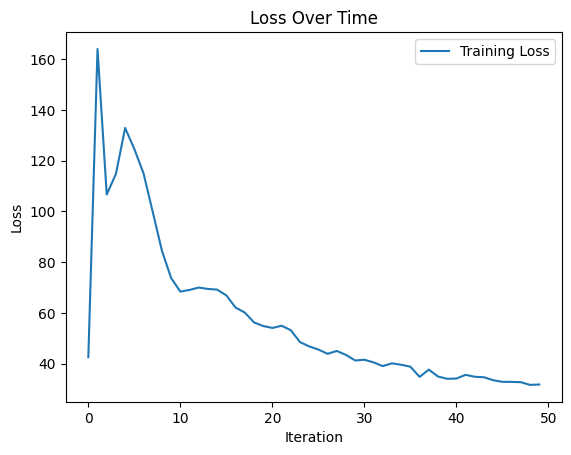

In [16]:
file_path = 'model_state_dict.pt'


#Training Loop
losses = []
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


if os.path.exists(file_path):
    #transformer = torch.load(file_path, weights_only=False)#.to(DEVICE)
    transformer.load_state_dict(torch.load(file_path))#, weights_only=True)
    transformer.to(DEVICE)
else:
    transformer = Transformer(cfg)#.to(DEVICE)

dataset = MODEL_DATA_CHUNKS

#for epoch in range(0,1):
#epoch_loss = 0

dataset_train = 50 # Dataset Training Size

# Variables for Progress Tracking
sample_i = 0
progress_step = max(1, dataset_train // 100)
print("Progress: 0%")

for sample in dataset[:dataset_train]:
    sample = torch.tensor(sample, dtype=torch.long).to(DEVICE)
    inputs = sample[:-1]#.to(DEVICE)
    targets = sample[1:]#.to(DEVICE)
    
    optimizer.zero_grad()
    outputs = transformer(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    #print(loss.item())
    
    sample_i += 1
    if sample_i % progress_step == 0 or sample_i == dataset_train:
        clear_output(wait=True)
        print(f"Progress: {sample_i / dataset_train * 100:.0f}%")

    torch.save(transformer.state_dict(), file_path)


plt.plot(losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()
plt.show()

# Generating Function

In [39]:

def generate(
	vocab: list[int],
	transformer: Transformer,
	initial_state: list[int],
	max_tokens: int = 10,
) -> list[int]:
	d_vocab: int = len(vocab)

	output: list[int] = torch.tensor(initial_state, dtype=torch.long).to(DEVICE)
	# print(output)
	for _ in range(max_tokens):
		next_state_probs = transformer.forward(output)
		# # print(next_state_probs[-1][21831])

		# # probs = torch.nn.functional.softmax(next_state_probs[-1], dim=-1)
		# # next_state_probs = torch.multinomial(probs, num_samples=1).squeeze()
		# next_state_probs = torch.argmax(next_state_probs[-1], dim=-1).squeeze()

		# # print("Raw logits:", next_state_probs[-1][:10])
		# # temperature = 0.8
		# # probs = torch.nn.functional.softmax(next_state_probs[-1] / temperature, dim=-1)
		# # next_state_probs = torch.multinomial(probs, num_samples=1).squeeze()
		# # #next_state_probs = next_state_probs[-1].unsqueeze(0)
		# # #output.append(next_state_probs)

		# output_temp = torch.cat((output, next_state_probs.unsqueeze(0)), dim=0)
		# output = torch.tensor(output_temp, dtype=torch.long).to(DEVICE)
		# print(output)


		probs = torch.nn.functional.softmax(next_state_probs[-1], dim=-1)

		next_token = torch.multinomial(probs, num_samples=1).squeeze()

		#Prevent repetition
		if next_token == output[-1]:
			#second most probable token instead
			sorted_probs, sorted_indices = torch.sort(probs, descending=True)
			next_token = sorted_indices[1].squeeze()

		output = torch.cat((output, next_token.unsqueeze(0)), dim=0)
		# print(output)

	return output.tolist()
		


def generate_text(
	transformer: Transformer,
	initial_state: str,
	tokenizer: transformers.PreTrainedTokenizer,
	max_tokens: int = 10,
) -> str:

	output: list[int] = tokenizer.encode(initial_state)#int
	output = generate(tokenizer.get_vocab().values(), transformer, output, max_tokens=max_tokens)

	return tokenizer.decode(output)
	# return output

print(generate_text(transformer, "The quick brown fox", TOKENIZER, max_tokens=10))

The quick brown fox 2017!aned martyrheard" readily contacts flooded"
